In [1]:
%cd ~/projects/kaggle/quora

/Users/trung/projects/kaggle/quora


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
import nltk
import numpy as np
from __future__ import print_function, division
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import (paired_cosine_distances, paired_distances,
paired_euclidean_distances, paired_manhattan_distances)

## Read data

In [4]:
# read data
d = pd.read_csv("data/raw/train.csv")
dt = pd.read_csv("data/raw/test.csv")
d['question1'].fillna('', inplace=True)
d['question1'] = d['question1'].map(lambda x: x.replace(' ?', '?'))
d['question2'].fillna('', inplace=True)
d['question2'] = d['question2'].map(lambda x: x.replace(' ?', '?'))
dt['question1'].fillna('', inplace=True)
dt['question1'] = dt['question1'].map(lambda x: x.replace(' ?', '?'))
dt['question2'].fillna('', inplace=True)
dt['question2'] = dt['question2'].map(lambda x: x.replace(' ?', '?'))

## Initial exploration

In [24]:
d.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
d.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [11]:
d.question1.apply(len).describe()

count    404290.000000
mean         59.576779
std          29.968286
min           1.000000
25%          39.000000
50%          52.000000
75%          72.000000
max         623.000000
Name: question1, dtype: float64

In [12]:
d.question2.apply(len).describe()

count    404290.000000
mean         60.143306
std          33.885970
min           0.000000
25%          39.000000
50%          51.000000
75%          72.000000
max        1169.000000
Name: question2, dtype: float64

Not many outliers in terms of question length

In [15]:
print(d.question2.apply(len).quantile(0.9999))
print(d.question1.apply(len).quantile(0.9999))

435.277499999
303.1422


Pipeline for creating feature with each vectorizer:

vectorizer => dimensionality reduction methods => similarity measures
so total features is num_vectorizers x num_dimen_reduc_method x num_metrics

## Converting documents to vectors

First we convert questions to vectors using various methods: bag of words, tf-idf, hashing vectorizer, etc.

In [5]:
x = pd.concat([d.question1, d.question2, dt.question1, dt.question2])
x = x.apply(lambda o: o.strip()).apply(lambda o: o.lower())
# vector representations
# - bag of words, tf-idf, stemming vs. no stemming, n-grams, skip-grams, embedding (todo)
vectorizers = [
    # uni-gram based on words
    CountVectorizer(token_pattern=r'\w+', analyzer='word'),
    HashingVectorizer(token_pattern=r'\w+', analyzer='word'),
    TfidfVectorizer(token_pattern=r'\w+', analyzer='word'),
    # uni-gram and bi-grams based on word
    CountVectorizer(token_pattern=r'\w+', analyzer='word', ngram_range=(1,2)),
    HashingVectorizer(token_pattern=r'\w+', analyzer='word', ngram_range=(1,2)),
    TfidfVectorizer(token_pattern=r'\w+', analyzer='word', ngram_range=(1,2)),
    # n-grams based on chars in words boundary
    CountVectorizer(token_pattern=r'\w+', analyzer='char_wb', ngram_range=(2,5)),
    HashingVectorizer(token_pattern=r'\w+', analyzer='char_wb', ngram_range=(2,5)),
    TfidfVectorizer(token_pattern=r'\w+', analyzer='char_wb', ngram_range=(2,5))
]

In [6]:
def distances(X, Y):
    dists = {
        'cosine': paired_cosine_distances(X, Y),
        'manhattan': paired_manhattan_distances(X, Y),
        'euclidena': paired_euclidean_distances(X, Y)
    }
    return pd.DataFrame(dists)

We compute features for each vectorizer to avoid keeping all vectorizers in memory.

In [7]:
from sklearn.decomposition import NMF
n_train = len(d)
n_test = len(dt)
x_train = pd.DataFrame()
x_test = pd.DataFrame()
for i, vectorizer in enumerate(vectorizers):
    print('vectorizer ', i)
    docvecs = vectorizer.fit_transform(x.values[0:100])
    tr_q1 = docvecs[0:n_train]
    tr_q2 = docvecs[(n_train):(n_train*2)]
    test_q1 = docvecs[(n_train*2):(n_train*2+n_test)]
    test_q2 = docvecs[(n_train*2+n_test):(n_train*2+n_test*2)]
    x_train = pd.concat([x_train, distances(tr_q1, tr_q2)], axis=1)
    x_test = pd.concat([x_test, distances(test_q1, test_q2)], axis=1)
    # too slow
    #nmf = NMF(n_components = 50, init='nndsvd')
    #nmf.fit(docvecs[0:(n_train*2)])
    #tr_q1 = nmf.transform(tr_q1)
    #tr_q2 = nmf.transform(tr_q2)
    #test_q1 = nmf.transform(test_q1)
    #test_q2 = nmf.transform(test_q2)

x_train.columns = ['x' + str(i) for i in xrange(x_train.shape[1])]
x_test.columns = ['x' + str(i) for i in xrange(x_test.shape[1])]

vectorizer  0
vectorizer  1
vectorizer  2
vectorizer  3
vectorizer  4
vectorizer  5
vectorizer  6
vectorizer  7
vectorizer  8


In [9]:
x_train.shape

(404290, 27)

Let's save the features.

In [10]:
x_train.to_csv('data/processed/train_set2.csv', index=False)
x_test.to_csv('data/processed/test_set2.csv', index=False)

## Dimensionality reduction

Using the document vectors from previous step, we can create lower dimensional representation using various methods: PCA, SVD, t-SNE, etc.

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor (koh-i-noor) dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely? how can i solve...
4    which one dissolve in water quikly sugar, salt...
dtype: object
117065
  (0, 55014)	1
  (0, 67687)	1
  (0, 97468)	1
  (0, 54666)	2
  (0, 56769)	1
  (0, 108628)	1
  (0, 48676)	1
  (0, 21060)	1
  (0, 102520)	2
  (0, 107442)	1
  (0, 57239)	1
  (0, 117065)	1


### Cosine similarity

In [128]:
paired_cosine_distances([[1, 1, 0]], [[1, 0, 1]])

array([ 0.5])

In [52]:
cosine = paired_cosine_distances(tr_q1[0], tr_q2[0])

In [53]:
d.loc[cosine == 0, ['question1', 'question2', 'is_duplicate']].head(20)

,question1,question2,is_duplicate


In [208]:
print(d.question1[1707])
print(d.question2[1707])

Where can I watch the walking dead season 8 online?
Where can I watch The Walking Dead season 7 online?


So we see that there are pairs that are not duplicated eventhough cosine similarity is 0. Many of these are due to numbers, e.g. two different editions of a same thing. So our tokenizer should not exclude numbers.

Also, what's the correlation between target and cosine similarity?

In [229]:
np.corrcoef(cosine, d.is_duplicate.values)

array([[ 1.        , -0.35322171],
       [-0.35322171,  1.        ]])

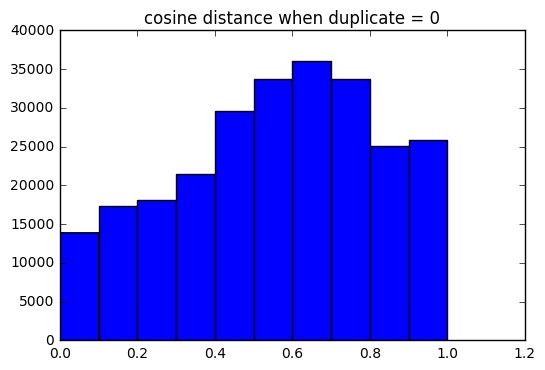

In [230]:
plt.hist(cosine[d.is_duplicate == 0])
plt.title('cosine distance when duplicate = 0')

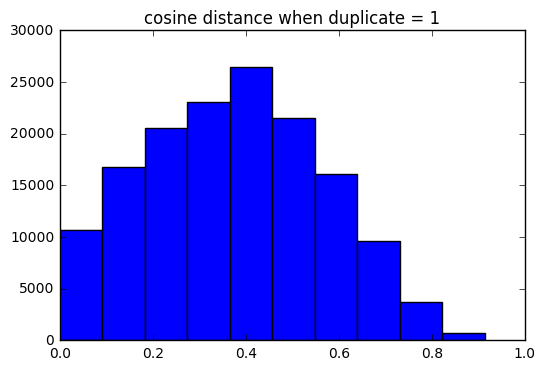

In [231]:
plt.hist(cosine[d.is_duplicate == 1])
plt.title('cosine distance when duplicate = 1')

We see a strong correlation between cosine distance and the labels, so this is a good feature.

## Building model

Finally we build a binary classifier.

In [37]:
x_train = pd.read_csv('data/processed/train_set2.csv')
x_test = pd.read_csv('data/processed/test_set2.csv')

### Re-sample data to match test set distribution

Here we over sample the negative class such that proportion of positives vs. negatives is relatively same in both train and test. This gives better calibration for log-loss. We must be careful and re-sample the training set only (after spliting train and validation).

In [5]:
def resample(x_train, y_train):
    pos_train = x_train[y_train == 1]
    neg_train = x_train[y_train == 0]

    # Now we oversample the negative class
    # There is likely a much more elegant way to do this...
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
    print(len(pos_train) / (len(pos_train) + len(neg_train)))

    x_train = pd.concat([pos_train, neg_train])
    y_train = np.hstack(((np.ones(len(pos_train))), np.zeros(len(neg_train))))
    return x_train, y_train

In [11]:
# we could also do as others (sample first, then split),
# but then validation won't be effective and have to use early stopping say when train error is 0.2 something
y = d.is_duplicate.values
X_train, X_val, y_train, y_val = train_test_split(x_train, y, test_size=0.2, random_state=1110)
X_train, y_train = resample(X_train, y_train)

0.191260105603


In [13]:
print(sum(y == 1) / len(y))
print(sum(y_train == 1) / len(y_train))

0.369197853026
0.191260105603


In [14]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((624035, 27), (80858, 27), (624035,), (80858,))

In [15]:
import lightgbm as lgb

In [23]:
# 0.227 (train log-loss), 0.495 nleaves = 64, lrate = 0.1, #trees = 1819
# 0.241, 0.491 nleaves = 64, lrate = 0.1, #trees = 3000 (not stopping yet)
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt', # or dart
                           num_leaves=64, # log2(num_leaves) => max_depth in xgboost
                           learning_rate=0.05,
                           n_estimators=3000, # num trees
                           min_child_weight=1,
                           subsample=0.7,
                           colsample_bytree=0.7,
                           seed=1234)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          eval_metric='logloss',
          early_stopping_rounds=50
         )

[1]	valid_0's binary_logloss: 0.668586	valid_1's binary_logloss: 0.677505
Train until valid scores didn't improve in 50 rounds.
[2]	valid_0's binary_logloss: 0.646378	valid_1's binary_logloss: 0.663655
[3]	valid_0's binary_logloss: 0.626188	valid_1's binary_logloss: 0.651247
[4]	valid_0's binary_logloss: 0.607699	valid_1's binary_logloss: 0.640015
[5]	valid_0's binary_logloss: 0.590804	valid_1's binary_logloss: 0.629954
[6]	valid_0's binary_logloss: 0.575316	valid_1's binary_logloss: 0.620898
[7]	valid_0's binary_logloss: 0.561046	valid_1's binary_logloss: 0.612685
[8]	valid_0's binary_logloss: 0.547961	valid_1's binary_logloss: 0.605405
[9]	valid_0's binary_logloss: 0.535854	valid_1's binary_logloss: 0.598704
[10]	valid_0's binary_logloss: 0.524693	valid_1's binary_logloss: 0.592688
[11]	valid_0's binary_logloss: 0.514373	valid_1's binary_logloss: 0.587281
[12]	valid_0's binary_logloss: 0.504795	valid_1's binary_logloss: 0.582347
[13]	valid_0's binary_logloss: 0.495906	valid_1's binar

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.05, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=1,
        min_split_gain=0, n_estimators=3000, nthread=-1, num_leaves=64,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=1234, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.7,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [32]:
model.feature_importance()

/Users/trung/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function feature_importance is deprecated; Use attribute feature_importances_ instead.
  warnings.warn(msg, category=DeprecationWarning)


array([ 0.03746984,  0.01597143,  0.01196825,  0.02288571,  0.0138127 ,
        0.04370159,  0.05805397,  0.03791111,  0.0594127 ,  0.03866032,
        0.01554921,  0.01091746,  0.02238413,  0.01246349,  0.04142222,
        0.05708572,  0.03973333,  0.05937778,  0.06050476,  0.05440635,
        0.04905397,  0.02494286,  0.0104127 ,  0.05360318,  0.06827302,
        0.02293651,  0.05708572], dtype=float32)

## Evaluate the classifier

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from matplotlib import pyplot as plt
def evaluate(label, pred_prob, pred_label):
    plt.hist(pred_prob[label == 1])
    plt.title('positive class')
    plt.figure()
    plt.hist(pred_prob[label == 0])
    plt.title('negative class')

    print(confusion_matrix(label, pred_label))
    print(classification_report(label, pred_label, target_names=['not duplicate', 'duplicate']))
    print(roc_auc_score(label, pred_prob))


[[500528   4154]
 [ 50759  68594]]
               precision    recall  f1-score   support

not duplicate       0.91      0.99      0.95    504682
    duplicate       0.94      0.57      0.71    119353

  avg / total       0.91      0.91      0.90    624035

0.9694276392


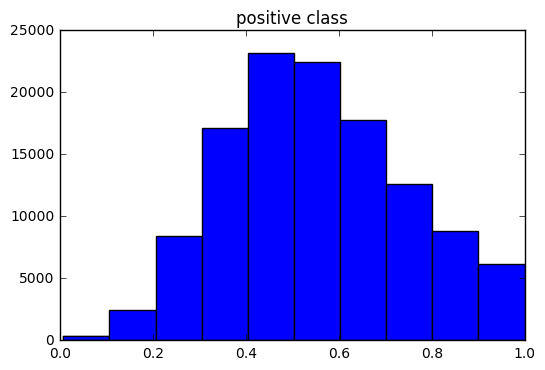

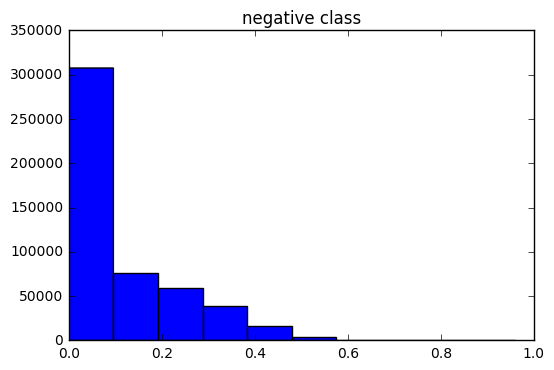

In [18]:
train_prob = model.predict_proba(X_train, num_iteration=model.best_iteration)[:,1]
train_label = model.predict(X_train, num_iteration=model.best_iteration)
evaluate(y_train, train_prob, train_label)

In [25]:
val_prob = model.predict_proba(X_val, num_iteration=model.best_iteration)[:,1]
val_label = model.predict(X_val, num_iteration=model.best_iteration)

KeyboardInterrupt: 

[[47761  3187]
 [19464 10446]]
               precision    recall  f1-score   support

not duplicate       0.71      0.94      0.81     50948
    duplicate       0.77      0.35      0.48     29910

  avg / total       0.73      0.72      0.69     80858

0.847642107842


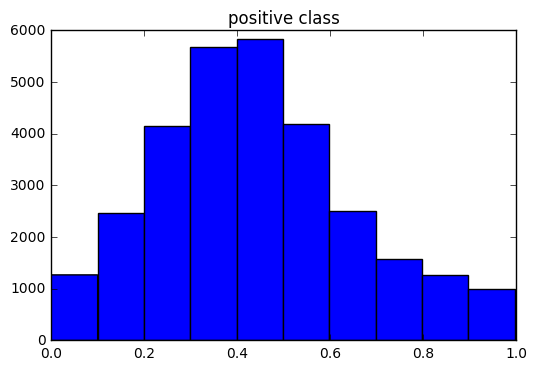

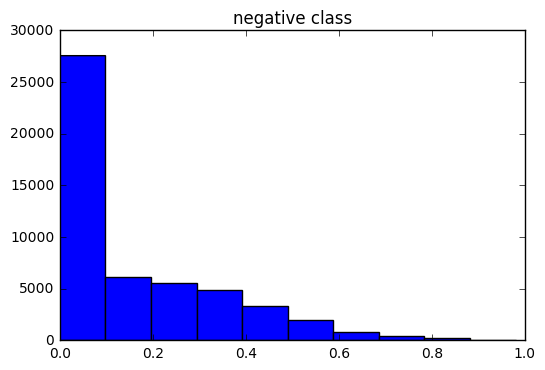

In [26]:
evaluate(y_val, val_prob, val_label)

Looks like model is not doing well for the positive class (poor recall and f1), but this could be due to 0.5 not the right threshold. 

#### Label is duplicate but model predicts with very low probability

Let's see what are the wrong cases?

In [26]:
wrong1 = X_train[np.logical_and(y_train == 1, train_prob < 0.1)].index

In [152]:
wrong1

Int64Index([ 16310, 212027,  38544, 129057, 403693, 155726, 239613,  43779,
            210488,   7477,
            ...
             26574, 144779, 402685, 214225, 215149, 249031, 288751,  53515,
            151619, 239867],
           dtype='int64', length=2567)

In [27]:
def print_some(d, indice):
    for i in indice:
        print(d.is_duplicate[i])
        print(d.question1[i])
        print(d.question2[i])


In [28]:
print_some(d, wrong1[0:10])

1
What are some tricks to alter/change my Quora feed if I am unhappy with my current one?
How do I optimize Quora feed perfectly?
1
What are the best motivational Weight loss transformation stories? I am 100 and I want to shed 30 kg.these stories will help.
What is the best weight loss story?
1
Do people find dimples attractive?
Why are dimples hot on girls?
1
How do I lose weight without stopping?
How do I lose weight without quitting?
1
What are the home remedies for acne?
What are the home remedies for pimples?
1
How many public libraries are there in the US?
How many public libraries are there in the USA?
1
Is astrology true? Should we believe it or not?
Do you believe in horoscope?
1
What should Indian youth not learn from Katrina Kaif?
What should Indian youth not learn from poonam pandey?
1
Is NASA's moon landing a hoax?
Is the moon landing fake because the astronaut suits are different in the images?
1
How do you factory reset a Toshiba Satellite Pro?
What are some ways of rest

It's quite clear that these are the hard case where similarities can't be determined from word occurence only. They will need to deal with through synonyms or word embedding. Some of them are quite subjective that I actually don't think are duplicate!

#### Label is not duplicate but model predicts very high

In [29]:
wrong2 = X_train[np.logical_and(y_train == 0, train_prob > 0.8)].index

In [30]:
print_some(d, wrong2[0:10])

0
How can I name these organic compounds?
How do I name these organic compounds?
0
How can I become physically strong?
How do I become physically strong?
0
What's the difference between the two Chinese characters?
What is the difference between the two Chinese characters?
0
What is your review of Reservation Road (2007 movie)?
What is your review of No Reservations (2007 movie)?
0
Who is real Indian?
Who is the real Indian?
0
How do you read tarot cards?
How do I read tarot cards?
0
How can I make a video like this?
How do I make a video like this?
0
What is good occupation for former software developers who want a slightly more social job?
What is a good occupation for former software developers who want a slightly more social job?
0
What is the Prodecessor?
What is Prodecessor?
0
How do I crack CLAT?
How do I crack the CLAT?


Again this is very subjective and many can indeed be classified as duplicate!

## Predict

In [38]:
y_pred = model.predict_proba(x_test, num_iteration=model.best_iteration)

In [36]:
x_test.shape, dt.shape

((404290, 27), (2345796, 3))

In [39]:
print(y_pred.shape)
print(np.mean(y_pred[:,1]))

(2345796, 2)
0.152261803656


In [31]:
calibrated = y_pred[:,1]*0.165/np.mean(y_pred[:,1])
np.mean(calibrated)

0.16500000000000009

In [41]:
sub = pd.DataFrame({'test_id': dt.test_id, 'is_duplicate': y_pred[:,1]})

In [42]:
sub.head()

,is_duplicate,test_id
0,0.033714,0
1,0.356675,1
2,0.405503,2
3,0.000016,3
4,0.116877,4


In [43]:
sub.to_csv('results/features2.csv', index=False)
#! gzip results/oversampled.csv

In [209]:
!cat results/tmp.csv

id,v
0,11
1,22
